<a href="https://colab.research.google.com/github/DM-ILLER/German-Credit-Risk/blob/main/credit_risk_estimation_oreilly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

Risk Bucketing - grouping borrowers with similar creditworthiness. Treating borrowerws wtih different risk levels equally may result in poor predictions because the model cannot capture entirely different characterisitcs of the data at once. Therefore, dividing the borrowers into different groups based on riskiness enables us to make more accurate predictions. 

In [3]:
from google.colab import files
files.upload()

Saving german_credit_data.csv to german_credit_data.csv


{'german_credit_data.csv': b',Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose\r\n0,67,male,2,own,NA,little,1169,6,radio/TV\r\n1,22,female,2,own,little,moderate,5951,48,radio/TV\r\n2,49,male,1,own,little,NA,2096,12,education\r\n3,45,male,2,free,little,little,7882,42,furniture/equipment\r\n4,53,male,2,free,little,little,4870,24,car\r\n5,35,male,1,free,NA,NA,9055,36,education\r\n6,53,male,2,own,quite rich,NA,2835,24,furniture/equipment\r\n7,35,male,3,rent,little,moderate,6948,36,car\r\n8,61,male,1,own,rich,NA,3059,12,radio/TV\r\n9,28,male,3,own,little,moderate,5234,30,car\r\n10,25,female,2,rent,little,moderate,1295,12,car\r\n11,24,female,2,rent,little,little,4308,48,business\r\n12,22,female,2,own,little,moderate,1567,12,radio/TV\r\n13,60,male,1,own,little,little,1199,24,car\r\n14,28,female,2,rent,little,little,1403,15,car\r\n15,32,female,1,own,moderate,little,1282,24,radio/TV\r\n16,53,male,2,own,NA,NA,2424,24,radio/TV\r\n17,25,male,2,own,NA,little,8072,

In [9]:
# Import the German credit dataset and drop the unecessary column
import pandas as pd

credit = pd.read_csv("german_credit_data.csv").drop(["Unnamed: 0"], axis=1)
credit.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [10]:
# View summary statistics
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


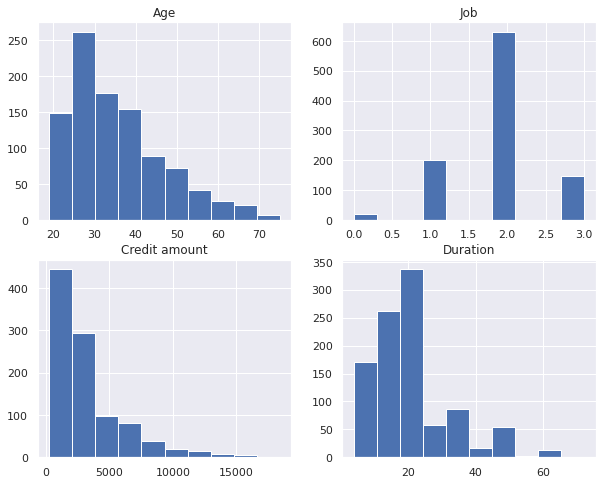

In [15]:
# Distributions of the numerical variables
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)

numerical_credit = credit.select_dtypes(exclude='O')

plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in enumerate(cols):
  k += 1
  plt.subplot(2, 2, k)
  plt.hist(numerical_credit.iloc[:, i])
  plt.title(j)

None of the numeric variables in the dataset follow a normal distribution. The age, credit amount, and duration variables are all skewed right.

## Deciding the Optimal Number of Clusters

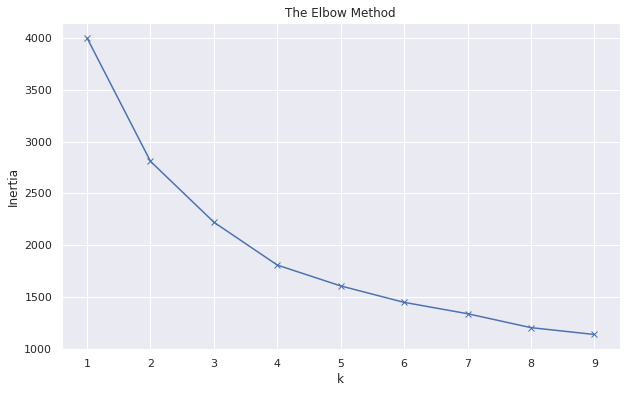

In [18]:
# The elbow method
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

distance = []
for k in range(1, 10):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(scaled_credit)
  distance.append(kmeans.inertia_)

plt.plot(range(1, 10), distance, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method')
plt.show()

The elbow method suggest that we use four clusters for risk bucketing.

In [ ]:
# Silhouette scores technique

In [ ]:
Given the ave